In [14]:
# Load libraries
import glob     
import numpy as np
import os

# manage file pathing
import sys
sys.path.append("..") # Adds higher directory to python modules path.

# Load pre-processing libraries
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
import torch

# load custom libraries 
from src.model_training import load_pretrained_model
# load custom defined constants 
from model_config import CLASSES,WEIGHTS_CLASS_IMBALANCE,EARLYSTOP,OPTIMIZER,LR_SCHEDULER

# Visualisation
import matplotlib.pylab as plt
import seaborn as sns
# set as seaborn’s default theme
sns.set()
from sklearn.metrics import classification_report

# Speeds up convolutiosn by trying different algorithms for computing convolutions
torch.backends.cudnn.benchmark = True

# Load the data path to images
# Rmb to mount your Gdrive
IMG_DIR = '../data/train'

# Batch Size
BATCH_SIZE = 64

# Label Map
label_map = {
    0: "ALB",
    1: "BET",
    2: "DOL",
    3: "LAG",
    4: "NoF",
    5: "OTHER",
    6: "SHARK",
    7: "YFT",
}

# We will assume that all images are of .jpg and .png extensions

In [6]:
def convert_all_images_from_png_to_jpg(IMG_DIR) -> None:
    """
    Converts all .png files to .jpg through PIL .convert("RGB")
    :param IMG_DIR: str

    """
    counter = 0 
    for path in glob.glob(f"{IMG_DIR}/*.png"):
            try:
                im = Image.open(path)
                rgb_im = im.convert("RGB")
                rgb_im.save(path.replace('.png','.jpg'))
                counter += 1
            except:
                print(f"Unable to convert image {path}")
    if counter > 0:
        print("Successfully converted all .png images")
    else:
        print("No .png images")

def build_train_df(IMG_DIR):
    train_labels_df = pd.read_csv(f"{IMG_DIR}/test_labels.csv")
    print(train_labels_df)
    train_data_df = pd.DataFrame([path.replace(f"{IMG_DIR}/","") for path in glob.glob(f"{IMG_DIR}/*.jpg")],columns=['image'])
    print(train_data_df)

    train_df = pd.merge(train_labels_df, train_data_df, how ='inner', on =['image'])
    return train_df

In [7]:
# Split our training dataset to train and valid
def perform_train_valid_split(train_dataset,test_size=0.3,shuffle=True):
    train, valid= train_test_split(
                                            np.arange(len(train_dataset.targets)),
                                            test_size=test_size,
                                            shuffle=shuffle
                                  )

    return train, valid

In [16]:
# For using our pre-trained model VGG16, we need to ensure that we use the exact same pre-processing steps
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15, resample=False, fillcolor=0),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
        )

# Load the training and validation dataset
try:  
  dataset = datasets.ImageFolder(IMG_DIR, transform=transform)
  print(dataset)  
except FileNotFoundError:
  raise Exception("Try running cd train and rm -r .ipynb_checkpoints as it causing confusion https://stackoverflow.com/questions/68229246/pytorch-torchvision-datasets-imagefolder-filenotfounderror-found-no-valid-file") 

CLASSES = list(set(dataset.targets))
print([label_map[i] for i in CLASSES])

# randomly split train and validation data, we could also do a simple splice of 0.5 train - 0.5 validate.
valid_split = 0.2
data_size = len(dataset)
valid_size =  int(data_size * valid_split)
train_size =  data_size - valid_size

train_dataset, valid_dataset = random_split(dataset, [train_size,valid_size],generator=torch.Generator().manual_seed(42))

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers = 2, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers = 2, pin_memory=True)

Dataset ImageFolder
    Number of datapoints: 3777
    Root location: ../data/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
               RandomAffine(degrees=[-40.0, 40.0], scale=(1, 2), shear=[-15.0, 15.0])
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )
['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']


c:\Users\cawin\anaconda3\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


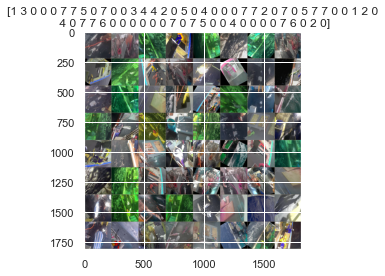

In [17]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(train_dataloader))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out,title=classes.numpy())

In [5]:
# Use cuda to enable gpu usage for pytorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# load model
model_ft = load_pretrained_model(model_name='vgg16', classes=CLASSES, device=device)
print(model_ft)

cpu
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [10]:
def weight_builder(IMG_DIR, clss_lst, data_size):
  weights = []
  for clss in clss_lst:
    num_of_samples = len(glob.glob(f"{IMG_DIR}/processed_data/{clss}/*jpg")) 
    weights.append(1 / (num_of_samples / data_size))
  return weights

class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

In [11]:
if WEIGHTS_CLASS_IMBALANCE:
    # Create weights to handle class imbalance (Used later)
    weights = weight_builder(IMG_DIR, CLASSES, train_size)
    print("Weight balanced is used.")
    print("Re-weight distribution:",weights)
    loss_fn = nn.CrossEntropyLoss(weight=torch.FloatTensor(weights).to(device))
else:
    print("No Weight balanced is used.")
    loss_fn = nn.CrossEntropyLoss()
if EARLYSTOP:
    print("Early stopping is enabled.")
    # Add early stopping as a regularizer for overfitting
    early_stopping = EarlyStopping(tolerance=5, min_delta=10)
if OPTIMIZER == 'Adam':
    print("Optimiser used:", OPTIMIZER)
    # We will use ADAM as our opitimiser to learn the optimal amount of gradient descent
    optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
else:
    print("Optimiser used: SGD")
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001)
if LR_SCHEDULER == 'Step':
    print("learning rate scheduler used: Step")
    # Exponentially Decay LR by a factor of 0.1
    exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
else:
    print("lr scheduler not found")

No Weight balanced is used.
Early stopping is enabled.
Optimiser used: Adam
learning rate scheduler used: Step


In [13]:
import copy
import time
plot_train_acc = []
plot_train_loss = []
plot_val_acc = []
plot_val_loss = []
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_dataloader
                dataset_size = train_size
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = valid_dataloader
                dataset_size = valid_size

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size
            if phase == 'train':
                plot_train_loss.append(float(epoch_loss))
                plot_train_acc.append(float(epoch_acc))
            if phase == 'val':
                plot_val_loss.append(float(epoch_loss))
                plot_val_acc.append(float(epoch_acc))

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
model_ft = train_model(model_ft, loss_fn, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(plot_train_acc, color='green', label='train accuracy')
plt.plot(plot_val_acc, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('../images/train_val_accuracy.png')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(plot_train_acc, color='green', label='train loss')
plt.plot(plot_val_acc, color='blue', label='validataion loss')
plt.legend()
plt.savefig('../images/train_val_loss.png')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(plot_train_acc, color='green', label='train accuracy')
plt.plot(plot_train_loss, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('../images/train_accuracy_loss.png')
plt.show()

In [ ]:
torch.save(model_ft, '../models/VGG16_v3_25_0.672.pt')

In [ ]:
print(plot_train_acc)
print(plot_train_loss)
print(plot_val_acc)
print(plot_val_loss)